**Last Update:** 2022/04/16

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.metrics import auc, roc_curve, classification_report
from datetime import datetime, date, time, timedelta

from scipy import stats


%matplotlib inline
sns.set(style="white",context="talk")

In [3]:
df = sns.load_dataset("tips")

In [4]:
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


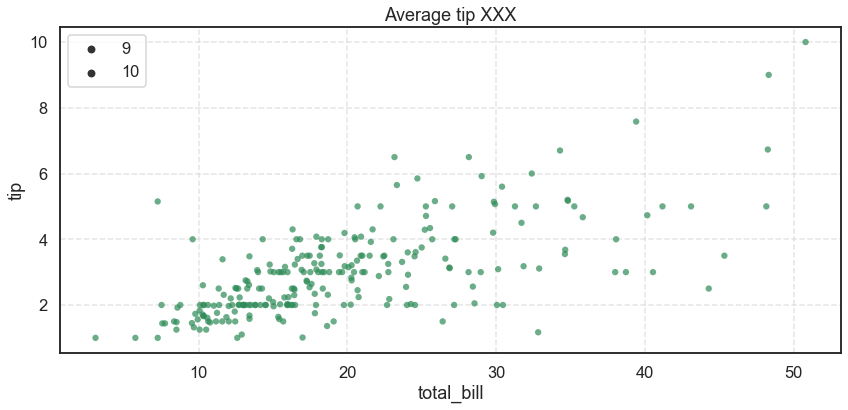

In [25]:
eda_plot(df,'total_bill','tip','scatterplot')

In [ ]:
# def eda_plot(df,col_x,col_y, plot_type,col_dt="",figsize_x=14, figsize_y=6):

def eda_()

# Data Preview and Processing

### Read in Large File 

In [ ]:
def read_csv_chunk(filepath,chunksize):
    num_of_chunk = 0

    df = pd.DataFrame()

    for chunk in pd.read_csv(filepath, sep=',',
                             chunksize=chunksize):
        num_of_chunk += 1
        df = pd.concat([df, chunk], axis=0)
        print('Processing Chunk No. ' + str(num_of_chunk))     

    print("The dataset's shape: ", df.shape)
    df.reset_index(inplace=True)
    return df

In [ ]:
def read_zip_csv_chunk(filepath, filename, chunksize):
    num_of_chunk = 0

    df = pd.DataFrame()
    zf = zipfile.ZipFile(filepath) 

    for chunk in pd.read_csv(zf.open('tweets.csv'), 
                             delimiter=';', skiprows=0, lineterminator='\n',
                             chunksize=chunksize):
        num_of_chunk += 1
        df = pd.concat([df, chunk], axis=0)
        print('Processing Chunk No. ' + str(num_of_chunk))     

    print("The dataset's shape: ", df.shape)
    df.reset_index(inplace=True)
    return df

### Data Preivew

In [27]:
def view(df):
    # Exploring the data types, number of unique values and missing values
    cols = df.columns
    print(f"The dataset consists of {df.shape[0]} rows and {df.shape[1]} columns")
    print(f"The columns are: {df.columns.tolist()}")
    return pd.concat([pd.DataFrame({
        "data_types":df.dtypes, 
              "value_counts": df.nunique(),
             "null_counts": df.isnull().sum()}).T,df.iloc[0:3,:]],axis = 0)

### Date
Should be really careful when the original ts_col is called "date" (overlapping with the date column we are about to generate)

In [1]:
def add_date_factors(df, ts_col, is_datetime):
    '''
    Assumption: the currect ts_col is a timestamp datatype
    
    Input:
    df (dataframe, target dataframe to be transformed)
    ts_col(string, name of the timestamp column)
    is_datetime(boolean, whether ts_col is datetime object or not)
    
    Output:
    This function generates hour, hour_of_day, date, weekday, week_of_month, months, year
    '''
    if is_datetime:
        pass
    else:
        df[ts_col] = list(map(lambda x: datetime.fromisoformat(x),df[ts_col].replace(":60",":59", regex=True)))

    # Hour
    df["hour"] = list(map(lambda x: x.hour, df[ts_col]))    

    # Hour of day
    def get_hourday(x):
        if 0<= x < 6:
            return "midnight"
        elif 6<= x < 12:
            return "morning"
        elif 12<= x < 18:
            return "afternoon"
        else:
            return "night"
    df["hourday"] = list(map(lambda x: get_hourday(x), df["hour"]))
        
    # Date
    df["date"] =  list(map(lambda day:day.date(), df[ts_col]))

    # Weekday
    wkday_dict = {1:"Mon",2:"Tue",3:"Wed",4:"Thu",5:"Fri",6:"Sat",7:"Sun"}
    df["weekday_index"] = list(map(lambda x: x.date().weekday()+1, df[ts_col]))
    df['weekday'] = list(map(lambda x: wkday_dict[x],df["weekday_index"]))

    # Week_of_month (assuming 4 weeks in a month)
    def get_week(day):
        if 1<= day.day < 8:
            return ("first_week",1)
        elif 8<= day.day < 15:
            return ("second_week",2)
        elif 15<= day.day < 22:
            return ("third_week",3)
        else:
            return ("last_week",4)
    df["week"] = list(map(lambda day: get_week(day)[0], df[ts_col]))
    df["week_index"] = list(map(lambda day: get_week(day)[1], df[ts_col]))

    # Month
    month_dict = {1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}
    df["month_index"] = list(map(lambda day: day.month, df[ts_col]))
    df["month"] = list(map(lambda m: month_dict[m], df["month_index"]))

    # Year
    df["year"] = list(map(lambda x:x.year,df[ts_col]))
    return df

### Reduce_memory

In [1]:
def reduce_mem(df):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('{:.2f} Mb, {:.2f} Mb ({:.2f} %)'.format(start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# EDA

## Visualization

### Comprehensive Summary

In [6]:
def subplot_loop(df, nrows, ncols, columns, figsize=(20,12)):
    '''
    This subplot_loop functions enable matrix-wise subplots.
    
    Input:
        df: dataframe 
        nrows: number of rows of the subplot
        ncols: number of columns of the subplot
        columns: a list of columns that will be visualized in the subplots in order
        figsize: a tuple of figure size
    Output:
        None
        
    '''
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, dpi=120, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        # Key highlights! => axes.flatten creates a iterable sequence
        data = df[columns[i]]        
        ax.plot(data, color= 'royalblue', linewidth=1)
        ax.set_title(dataset.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines['top'].set_alpha(0)
        ax.tick_params(labelsize=6)
    plt.tight_layout()

In [6]:
def eda_plot(df,col_x,col_y, plot_type,col_dt="",figsize_x=14, figsize_y=6):
    '''
    This helper function integrates boxplot, barchart, distribution-plot all together. 
    The plot_type parameter controls the output graph format.
    
    Input:
        df: PANDAS DATAFRAME
        col_dt: STRING, the column name of the date variable
        col_x: STRING, the column name of the key independent variable 
        col_y: STRING, the column name of the key dependent variable
        plot_type: STRING, including boxplot, categorical plot, histogram plot for continuous variables
        figsize_x: INT, control the length of the figure canvas
        figsize_y: INT, control the width of the figure canvas
    Output:
        None
    '''
    if plot_type == 'boxplot':
        # Test outliers by checking the distribution of active_mins
        f = plt.figure(figsize = (figsize_x,figsize_y))
        sns.boxplot(data = df[col_x], color = "yellowgreen")

        plt.title(f"{col_x} Distribution: No Apparently Erroneous Reported Age")
        plt.ylabel(col_x)
        plt.xlabel(col_x)
        plt.xticks([]) # remove the labels on the x-axis
        plt.show()        
    elif plot_type == 'catplot':
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(figsize_x,figsize_y))
        sns.countplot(x=col_x, 
                      data=df.sort_values(by = col_x),ax=axes[0],palette=sns.color_palette("viridis",df[col_x].nunique()))
        axes[0].set_title(f'Count Plot of {col_x}', fontsize=14)
        axes[0].grid(linestyle="--", alpha=0.2)

        sns.barplot(x=col_x, y=col_y, 
                    data=df.sort_values(by = col_x), ci=0, ax=axes[1],palette=sns.color_palette("viridis",df[col_x].nunique()));
        axes[1].set_title(f'Mean Conversion Rate by {col_x}', fontsize=14)
        axes[1].grid(linestyle="--", alpha=0.2)

        fig.suptitle("XX", fontsize = 16)
        plt.show()
    elif plot_type == 'histplot':
        sns.set(style="white",context="talk")
        grouped = df.groupby(col_x)[col_y].mean().reset_index()
        hist_kws={'histtype': 'bar', 'alpha': 0.2}

        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(figsize_x,figsize_y))
        sns.distplot(df[df[col_y] == 0][col_x],
                     label='XXX', ax=axes[0], hist_kws=hist_kws)
        sns.distplot(df[df[col_y] == 1][col_x], 
                     label='XXX', ax=axes[0], hist_kws=hist_kws)
        axes[0].set_title(F'Density of {col_x}', fontsize=16)
        axes[0].set_xlabel(col_x,fontsize = 16)
        axes[0].legend()
        axes[0].grid(linestyle="--", alpha=0.3)

        axes[1].plot(grouped[col_x], grouped[col_y])
        axes[1].set_title(f'Mean Conversion across {col_y}', fontsize=16)
        axes[1].set_xlabel(col_x,fontsize = 16)
        axes[1].set_ylabel('Mean Conversion',fontsize = 16)
        axes[1].grid(linestyle="--", alpha=0.3)

        fig.suptitle("XXXXX", fontsize = 18)
        plt.show()   
    elif plot_type == 'lineplot':
        grouped = df.groupby([col_dt,col_x])[col_y].mean().reset_index()

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(figsize_x,figsize_y))
        sns.lineplot(x=col_dt, y=col_y,hue = col_x,
                     # marker = 'o', markersize = 7,
                     data=grouped,ax=ax,
                    palette =sns.color_palette("viridis",df[col_x].nunique()))
        ax.set_title(f"Average {col_y} XXX")
        ax.set_ylabel(f"{col_y}")
        plt.show()
    elif plot_type == 'scatterplot':
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(figsize_x,figsize_y))
        sns.scatterplot(
            x=col_x, y=col_y,# hue = ?,
            data=df,ax=ax,
            size=10, 
            linewidth= 0, # get ride of the surrounding frame
            alpha=0.7, # make it transparent so I could visualize how much they overlap
            color = 'seagreen',
            palette =sns.color_palette("viridis"))
        ax.set_title(f"Average {col_y} XXX")
        ax.set_ylabel(f"{col_y}")
        ax.grid(linestyle="--", alpha=0.5)
        plt.show()        

### Target Variable Correlation

In [ ]:
# Multi-variate analysis
corr_data = pd.get_dummies(df).corr()
plt.subplots(figsize=(24,12))
sns.heatmap(corr_data, annot=True, vmax=1, square=True, fmt='.2f')
plt.show()

### Boxplot

In [2]:
# Test outliers by checking the distribution of active_mins
f = plt.figure(figsize = (8,6))
sns.boxplot(data = df['active_mins'], color = "yellowgreen")

plt.title("Active Minutes Distribution: No Apparently Erroneous Reported Age")
plt.ylabel("Active Minutes")
plt.xlabel("Active Minutes")
plt.xticks([]) # remove the labels on the x-axis 

plt.show()

NameError: name 'df' is not defined

<Figure size 576x432 with 0 Axes>

### Categorical Variable Plot

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='age_range', data=data.sort_values(by = "age"),ax=axes[0],palette=sns.color_palette("viridis"))
axes[0].set_title('Count Plot of XXX', fontsize=14)
axes[0].grid(linestyle="--", alpha=0.2)

sns.barplot(x='age_range', y='converted', data=data.sort_values(by = "age"), ci=0, ax=axes[1],palette=sns.color_palette("viridis"));
axes[1].set_title('XXX', fontsize=14)
axes[1].grid(linestyle="--", alpha=0.2)

fig.suptitle("XX", fontsize = 14)
plt.show()

### Time Series Plot

In [ ]:
def lineplot(df, col_x, col_y, title, xlabel, ylabel, hide_xticks=True, figsize=(18, 6)):
    '''
    This lineplot visualizes the time series trend of key metrics col_y along time/date variable col_x.
    '''
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    sns.lineplot(x=col_x, y=col_y, marker= "o", markersize = 7,
                  data=df, ax=ax,
                color = 'royalblue'
                )
    ax.set_title(title,fontsize=18)
    ax.set_xlabel(xlabel,fontsize = 14)
    ax.set_ylabel(ylabel,fontsize = 14)
    if hide_xticks:
        ax.set_xticks(())
    ax.grid(linestyle="--", alpha=0.7)
    plt.show()

### Double-Axis Plots

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(34, 8))


sns.lineplot(x='year_month', y='btc_tweets_cnt',
              data=df,ax=ax,label = '# BTC Tweets',
            color = 'seagreen')
ax.set_title(f"Number of BTC Tweets vs. CPI Fluctuation",fontsize=16)
ax.set_xlabel('Month (from 2012/01 to 2019/11)',fontsize = 16)
ax.set_ylabel(f"BTC Tweets",fontsize = 16)
ax.set_xticks(())
ax.legend(loc=0)

ax_y = ax.twinx() # Key for double-axis
sns.lineplot(x='year_month', y='cpi_year_diff', 
              data=cpi_df, ax=ax_y, label = 'CPI-YoY',
            color = 'royalblue'
)
ax_y.set_xticks(())
ax_y.set_ylabel(f"CPI-YoY",fontsize = 16)
ax_y.legend(loc=1)


### Numerical Variable Plot

In [ ]:
# Visualization of different sources
# palette=sns.color_palette("viridis")?

sns.set(style="white",context="talk")
grouped = data.groupby('purchase_value')["class"].mean().reset_index()
hist_kws={'histtype': 'bar', 'alpha': 0.2}

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['class'] == 0]['purchase_value'],
             label='Not Fraud', ax=axes[0], hist_kws=hist_kws)
sns.distplot(data[data['class'] == 1]['purchase_value'], 
             label='Fraud', ax=axes[0], hist_kws=hist_kws)
axes[0].set_title('Density of purchase_value', fontsize=16)
axes[0].set_xlabel('purchase_value',fontsize = 16)
axes[0].legend()
axes[0].grid(linestyle="--", alpha=0.3)


#sns.relplot(x = "purchase_value",y="class", data = data,kind = "line",ci = None,ax = axes[1])
axes[1].plot(grouped['purchase_value'], grouped['class'])
axes[1].set_title('Fraudulent Rate vs. purchase_value', fontsize=16)
axes[1].set_xlabel('purchase_value',fontsize = 16)
axes[1].set_ylabel('Fraudulent Rate',fontsize = 16)
axes[1].grid(linestyle="--", alpha=0.3)

fig.suptitle("Fraudulent Rate fluctuates around 9% but gets more volatile as value becomes larger", fontsize = 18)
plt.show()

## Tables

### Imputing Missing Values

1. KNN Imputation

In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)
df= pd.DataFrame(imputer.fit_transform(df))

2. Mean Imputation

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
df= pd.DataFrame(imputer.fit_transform(df))

### Counting the Values and Quantifying in Distribution
A really useful package&function - `Counter()`

In [8]:
from collections import Counter
values_dict = dict(zip(["a","b","c","d","f"],[1,1,2,3,1]))

distribution_dict = Counter(values_dict.values())
distribution_dict

Counter({1: 3, 2: 1, 3: 1})

In [9]:
# Calculate degree distribution: P(k) = N_k/N
# probability of a node having degree k
p_k = [(key, count / len(distribution_dict))
       for key, count in distribution_dict.items()]

p_k = sorted(p_k) # sort p_k (a list of tuples) in ascending order
print(p_k[:5]) # print the first 5 items

[(1, 1.0), (2, 0.3333333333333333), (3, 0.3333333333333333)]


## Hypothesis Testing

### Check Distribution being Normal

In [3]:
def check_normal_dist(data1, data2, method):
    '''
    This function checks whether two series (data1 and data2) is sampled from normal distribution 
    via different methods to ensure robustness.
    '''
    if method == 'ks_test':
        # 1. Check Kolmogorov-Smirnov test result
        print("KS-Test for the treatment group: ",stats.kstest(data1, 'norm'))
        print("KS-Test for the control group: ",stats.kstest(data2, 'norm'),"\n")
    elif method == 'shapiro':
        # 2. Check Shaporio-Wilk test result
        print(f'Shapiro–Wilk test for the treatment group: The p-value is {stats.shapiro(data1)[1]}')
        print(f'Shapiro–Wilk test for the control group: The p-value is {stats.shapiro(data2)[1]}')
    elif method == 'qq_plot':
        # 3. Visualize normality using Q-Q plot
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
        stats.probplot(data1, dist="norm", plot=axes[0])
        axes[0].set_title("Treatment Group: Q-Q Plot for Active Minutes", fontsize = 16)
        stats.probplot(data2, dist="norm", plot=axes[1])
        axes[1].set_title("Control Group: Q-Q Plot for Active Minutes", fontsize = 16)
        fig.suptitle("Q-Q Plot Normality Check: Total minutes per user in each group", fontsize = 20)
    elif method == 'hist':
        # 4. Visualize normality using histogram
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22,10))
        sns.distplot(data1,
                  hist_kws = {'histtype': 'bar', "color": 'green','alpha': 0.4},
                  kde_kws={"lw": 2,"alpha":0.8,"linestyle":'--'},
                  ax=axes[0])
        axes[0].set_xlabel('Active Minutes') 
        axes[0].set_ylabel('Probability')
        axes[0].set_title(f'Treatment Group: Histogram for Active Minutes',fontsize = 16) 
        sns.distplot(data2,
                  hist_kws = {'histtype': 'bar', "color": 'green','alpha': 0.4},
                  kde_kws={"lw": 2,"alpha":0.8,"linestyle":'--'},
                  ax=axes[1])
        axes[1].set_xlabel('Active Minutes')  
        axes[1].set_ylabel('Probability') 
        axes[1].set_title(f'Control Group: Histogram for Active Minutes',fontsize = 16) 
        
    elif method == 'hist_norm':
        # 5. Visualize normality using histogram (normal distribution as fde)
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22,10))
        num_bins = 50  

        mu =np.mean(data1) 
        sigma =np.std(data1) 
        n, bins, patches = axes[0].hist(data1, num_bins,normed=1, facecolor='green', alpha=0.5) 
        y = norm.pdf(bins, mu, sigma) 
        axes[0].plot(bins, y, 'b--') 
        axes[0].set_xlabel('Active Minutes')
        axes[0].set_ylabel('Probability')
        axes[0].set_title(f'Treatment Group: Histogram for Active Minutes (mu = {round(mu)}; sigma = {round(sigma)})',fontsize = 16) 

        mu =np.mean(data2) 
        sigma =np.std(data2)  
        n, bins, patches = axes[1].hist(data2, num_bins,normed=1, facecolor='green', rwidth = 0.7,alpha=0.5) 
        y = norm.pdf(bins, mu, sigma)
        axes[1].plot(bins, y, 'b--') 
        axes[1].set_xlabel('Active Minutes') 
        axes[1].set_ylabel('Probability')
        axes[1].set_title(f'Control Group: Histogram for Active Minutes (mu = {round(mu)}; sigma = {round(sigma)})',fontsize = 16) 
        fig.suptitle("Histogram Normality Check: Total minutes per user in each group\n Note: The blue curve depicts normal distribution ", fontsize = 20)        
    else:
        print("Unrecognized Method")  

### Check Homogeneous Variance

In [ ]:
def check_homo_var(data1, data2):
    '''
    This function checks the homogeneous variance assumption for independent t-test, 
    which is required if implementing AB experiment.
    
    '''
    # 1: Check levene test result
    t,p = stats.levene(data1,data2)
    print(f"Levene variance test: t={round(t,3)}, p={round(p,3)}")


### Check Sampling Distribution being Random

In [4]:
def plot_samp_dist(data, metric_col, dim_col, group_col,id_col,fig_size = [22,10],matrix=[1,2]):
    fig, axes = plt.subplots(nrows=matrix[0], ncols=matrix[1], figsize=(fig_size[0], fig_size[1]))

    SIZE_EXPT = data[data[group_col] == 1][id_col].nunique()
    SIZE_CTRL = data[data[group_col] == 0][id_col].nunique()

    tmp_by_dim = data.groupby(by=[dim_col,group_col,id_col])[metric_col].sum().reset_index().groupby(by= [dim_col,group_col]).agg(
        {id_col:"nunique",metric_col:"mean"}).reset_index().sort_values(id_col,ascending = False)
    tmp_by_dim.columns = [dim_col,group_col,"cnt_"+id_col,metric_col]
    tmp_by_dim[dim_col+'_pct'] = 0
    tmp_by_dim.loc[tmp_by_dim[group_col] == 1,dim_col+'_pct'] = tmp_by_dim[tmp_by_dim[group_col] == 1]["cnt_"+id_col]/SIZE_EXPT
    tmp_by_dim.loc[tmp_by_dim[group_col] == 0,dim_col+'_pct'] = tmp_by_dim[tmp_by_dim[group_col] == 0]["cnt_"+id_col]/SIZE_CTRL

    sns.barplot(x=dim_col, y = dim_col+'_pct', hue = group_col, data=tmp_by_dim,
                ax=axes[0], palette=sns.color_palette("viridis", 2))
    axes[0].set_title(f'Sampling Distribution by {dim_col}', fontsize=18)
    axes[0].grid(linestyle="--", alpha=0.2)
    axes[0].legend(title = "Ctr=0/Exp=1",loc = 1)

    sns.barplot(x=dim_col, y=metric_col,hue = group_col, data=tmp_by_dim, 
                ci=0, ax=axes[1], palette=sns.color_palette("viridis", 2))
    axes[1].set_title(f'Active Minutes per User by {dim_col}', fontsize=18)
    axes[1].grid(linestyle="--", alpha=0.2)
    axes[1].legend(title = "Ctr=0/Exp=1",loc = 1)

    fig.suptitle(f"Random Sampling Check on {dim_col}: Comparing Experiment/Control Group",fontsize = 20)
    plt.show()    

### Statistical Test

In [ ]:
def levene_t_test(data1, data2):
    # Step1: Check normal distribution assumption
    print("Data1: KS-Test",stats.kstest(data1, 'norm'))
    print("Data1: KS-Test",stats.kstest(data2, 'norm'),"\n")
    
    # Step2: Check equality of variance (not required in paired t-test), only required in independent t-test
    t,p = stats.levene(data1,data2)
    print(f"Levene variance test: t={round(t,3)}, p={round(p,3)}")
    if p<0.05:
        print("----variance of the two group doesn't equal, reject the null hypothesis----")
        t,p = stats.ttest_ind(data1,data2, equal_var = False)
    else:
        t,p = stats.ttest_ind(data1,data2)
    print(f"Independent t-test: t={round(t,3)}, p={round(p,3)}")

In [ ]:
from scipy import stats
def anova_test(df, col, target_col):
    '''
    Assumption:
    df has date column
    
    df: test dataframe (pandas df)
    col: the column to be tested (string)
    '''
    args = []
    for value in df[col].unique():
        args.append(df[df[col] == value].groupby("date")[target_col].mean().values)
    f, p = stats.f_oneway(*args)

    print(f'For {col}: One-way ANOVA')
    print(f"Number of pairs of samples: {len(args[0])}")
    print('=============')

    print('F value:', round(f,4))
    print('P value:', round(p,4))

In [4]:
from scipy.stats import norm
def sampleSize_twoGroups(D, alpha=0.05, beta=0.2, sigma1=1, sigma2=1):
    '''
    Sample size for two groups
    '''
     
    n = np.round((norm.ppf(1-alpha/2.) + norm.ppf(1-beta))**2 * (sigma1**2 + sigma2**2) / D**2)
     
    print(('In order to detect a change of {0} between groups with an SD of {1} and {2},'.format(D, sigma1, sigma2)))
    print(('with significance {0} and test-power {1}, you need in each group at least {2:d} subjects.'.format(alpha, 100*(1-beta), int(n))))
     
    return n

# Modeling

### Train Test Split

In [ ]:
# hold out 20% as validation dataset for evaluation purpose
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=42)

### OLS / DID Regression

In [5]:
import statsmodels.formula.api as smf
def get_did_result(df,Y,time_var,group_var,time_group_var):
    did_est = smf.ols(formula=f'{Y} ~ {time_var} + {group_var} + {time_group_var}', data=df).fit() 
    print(did_est.summary()) 

### PCA Method

In [ ]:
# PCA for dimension reduction
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pca_viz(data):
    pca = PCA(n_components=2, random_state=42)
    pca = pca.fit(data)
    pca_output = pca.transform(data)

    # standardize the results
    return pd.DataFrame(StandardScaler().fit_transform(pca_output))


### KMeans
GridSearch to select the best K

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
# determine the best number of clusters
# Please replace the pca_data as the actual data in use
clusters = range(2, 20)
inertias = []
silhouettes = []

for n_clusters in clusters:
  # Set n_init=10 to run k-means clustering algorithm 10 times independently
  # with different centroids to choose the final model with the lowest SSE
    kmeans = KMeans(n_clusters = n_clusters, init='k-means++', n_init = 10, max_iter=300,random_state=123, n_jobs=-1)
    kmeans = kmeans.fit(pca_data)
    label = kmeans.predict(pca_data)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(pca_data, label))
    
# visualization
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax[0].plot(clusters, inertias, 'o-',color = "yellowgreen")
ax[0].set_title("Sum of Squared Distances: Decreasing constantly",fontsize = 16)
ax[0].axhline(y=inertias[4],ls="--",c="yellowgreen",alpha = 0.7)
ax[0].axvline(x=6,ls="--",c="yellowgreen",alpha = 0.7)
ax[0].grid(True)

ax[1].plot(clusters, silhouettes, 'o-',color = "orange")
ax[1].grid(True)
ax[1].axhline(y=silhouettes[4],ls="--",c="orange",alpha = 0.7)
ax[1].axvline(x=6,ls="--",c="orange",alpha = 0.7)
ax[1].set_title("Silhouette Coefficient: 6 clusters seem optimal",fontsize = 16)
plt.tight_layout()
plt.show()

### Resampling

In [3]:
# Undersample to recreate a balanced training set
def undersample(data, target_col):
    data_neg = data[data[target_col] == 0].sample(n=len(data[data[target_col] == 1]), random_state=111)
    return pd.concat([data_neg, data[data[target_col] == 1]],axis = 0)

### XGBoost

In [ ]:
from xgboost import XGBClassifier,XGBRegressor
from sklearn.model_selection import cross_val_score


xgb_reg = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=160, silent=False, objective='reg:gamma')
xgb_clf = XGBClassifier()

### Random Forest Classifier + RandomizedSearchCV

In [ ]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

rf_clf = RandomForestClassifier(oob_score = True, max_features='auto' ,random_state=10)
rf_parameters = {"n_estimators":[50,80,100], "max_depth":[3,5,7], "min_samples_split" :[2,5,8], "min_samples_leaf":[2,5,8]}
rf_random_search = RandomizedSearchCV(rf_clf, rf_parameters, n_jobs = -1, cv = 2, scoring = "roc_auc", n_iter = 15)
rf_random_search.fit(x_train, y_train.values.ravel())

print(rf_random_search.best_params_)
rf_clf_best = rf_random_search.best_estimator_
print(rf_clf_best.score(x_train, y_train))

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

def rfe_cv(clf, x_train, y_train, min_features_to_select):

    rfecv = RFECV(estimator = clf, step=1, cv=StratifiedKFold(2),min_features_to_select = min_features_to_select,
                  scoring='roc_auc')

    rfecv.fit(x_train, y_train.values.ravel())
    print(f"Optimal number of features : {rfecv.n_features_}, the optimal roc_auc score: {rfecv.grid_scores_.max()}\n")
    print(f"The {rfecv.n_features_} features selected: {x_train.columns[rfecv.support_].values}")

    # Plot number of features VS. cross-validation scores
    plt.figure(figsize = (12,6))
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(min_features_to_select,
                   len(rfecv.grid_scores_) + min_features_to_select),
             rfecv.grid_scores_, marker = "o", markersize = 3)
    #plt.plot(range(len(rfecv.grid_scores_)),
     #        rfecv.grid_scores_, marker = "o", markersize = 3)
    plt.grid(linestyle="--", alpha=0.3)
    plt.axvline(x = rfecv.n_features_, ls=":",c="green") 
    #plt.axhline(y = rfecv.grid_scores_.max(), ls=":", c="green")
    plt.text(rfecv.n_features_, rfecv.grid_scores_.max(),(rfecv.n_features_,round(rfecv.grid_scores_.max(),4)),color='green')
    plt.show()
    return rfecv


In [ ]:
rf_rfecv = rfe_cv(rf_clf_best, x_train, y_train, min_features_to_select = 3)

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_parameters = {"C":[0.3,0.4,0.5,0.6,0.7]}
lr_clf = LogisticRegression(penalty = "l2", solver = "sag")

lr_grid_search = GridSearchCV(lr_clf, lr_parameters, n_jobs = -1, cv = 10, scoring = "neg_log_loss")
lr_grid_search.fit(x_train_rf_shrink, y_train) # I am using x_train_rf_shrink

print(lr_grid_search.best_params_)
lr_clf_best = lr_grid_search.best_estimator_
print(lr_clf_best.score(x_train_rf_shrink, y_train)) # I am using x_train_rf_shrink

### Feature Importance Plot

In [ ]:
fea_imp = pd.DataFrame({"importance":[round(x,4) for x in rf_clf_best.feature_importances_],
                        "feature":x_train.columns[rf_rfecv.support_].values}).sort_values(by = "importance", ascending = False)
fig = plt.figure(figsize = (14,14))
sns.barplot(x = "importance", y = "feature", data = fea_imp)

In [ ]:
# Backup method
importances = pd.DataFrame({'feature':X_train.columns,
                            'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

# Plot the importance
importances.plot.bar()

# Performance Evaluation

### Classification Report

In [ ]:
# Get classification report
train_true = y_train
valid_true = y_valid
train_pred = rf_clf_best.predict_proba(x_train)[:,1]
valid_pred = rf_clf_best.predict_proba(x_valid)[:,1]

# Make predictions
train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
valid_fpr, valid_tpr, _ = roc_curve(valid_true, valid_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
valid_auc = np.round(auc(valid_fpr, valid_tpr), 3)

# F1-score = 2 * precision*recall / (precision+recall)
print(classification_report(y_true=valid_true, y_pred=(valid_pred > 0.5).astype(int),
                            target_names = ["negative:0","positive:1"]))

### ROC/AUC Plot
We expect the train and test curve to converge (otherwise we tend to have overfitting problem)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(valid_fpr, valid_tpr, label='Test AUC: ' + str(valid_auc))
ax.plot([0, 1], [0, 1], ls="--", c=".3")
ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=14)
ax.legend(fontsize=14)
plt.show()

### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
confmat = confusion_matrix(y_true = y_train, y_pred = blend_y_train, labels=[0, 1])

def draw_confmat(confmat):

    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()
    

### PR Curve

In [10]:
from sklearn.metrics import precision_recall_curve
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8])
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

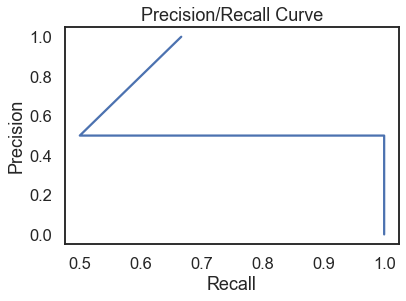

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
plt.figure(1) # 创建图表1
plt.title('Precision/Recall Curve')# give plot a title
plt.xlabel('Recall')# make axis labels
plt.ylabel('Precision')
 
#y_true和y_scores分别是gt label和predict score
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8])
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
plt.figure(1)
plt.plot(precision, recall)
plt.show()

In [26]:
# Backup Methods

from sklearn.metrics import precision_recall_curve

def plot_precision_and_recall(precision, recall, threshold):
    '''
    This graph is not technically a Precision vs. Recall Curve but rather a graph consists of the two curves  
    x-axis: threshold
    y-axis: absolute level for precision curve and recall curve
    '''
    plt.plot(threshold, precision[:-1], "royalblue", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "seagreen", label="recall", linewidth=5)
    plot_precision_and_recall(precision, recall, threshold)
    
    plt.figure(figsize=(14, 7))
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])
    plt.title('Precision and Recall Curve')
    plt.grid(linestyle="--",alpha=0.4)
    plt.show()

def plot_precision_vs_recall(precision, recall):
    plt.figure(figsize=(14, 7))
    plt.plot(recall, precision, "seagreen", linewidth=2.5)
    plt.ylabel("recall", fontsize=19)
    plt.xlabel("precision", fontsize=19)
    plt.title('Precision vs. Recall Curve')
    plt.grid(linestyle="--",alpha=0.4)
    plt.axis([0, 1.5, 0, 1.5])
    plt.show()